In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.svm import SVC
from mlxtend.plotting import plot_confusion_matrix

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data.shape

(14640, 15)

### Duplicate

In [6]:
data.duplicated().sum()

36

In [13]:
duplicateRow = data[data.duplicated()]
duplicateRow.sort_values("tweet_id", inplace = True)
duplicateRow.head()

<ipython-input-13-4120875fcb3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicateRow.sort_values("tweet_id", inplace = True)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12162,570272018840428544,neutral,1.0,NaN,NaN,American,NaN,pokecrastinator,NaN,0,@AmericanAir I thought all those planes were r...,NaN,2015-02-24 09:20:19 -0800,United States,Mountain Time (US & Canada)
12159,570272880556011520,positive,1.0,NaN,NaN,American,NaN,ESPartee,NaN,0,"@americanair new plane, #gogo, easy power for ...","[0.0, 0.0]",2015-02-24 09:23:44 -0800,"alexandria, va",Eastern Time (US & Canada)
12158,570273710210469888,positive,1.0,NaN,NaN,American,NaN,Mtts28,NaN,0,@AmericanAir These are some awesome photos. Th...,NaN,2015-02-24 09:27:02 -0800,Virginia,Eastern Time (US & Canada)
12157,570273819287531520,positive,1.0,NaN,NaN,American,NaN,GoldensPleasure,NaN,0,@AmericanAir Aww Thanks AA..DFW was on GMA up ...,NaN,2015-02-24 09:27:28 -0800,East Coast CT.,Central Time (US & Canada)
12155,570275010759102466,negative,1.0,Lost Luggage,1.0,American,NaN,paintbranch1398,NaN,0,@AmericanAir this delayed bag was for my frien...,NaN,2015-02-24 09:32:12 -0800,NaN,NaN


In [14]:
data.drop_duplicates(keep='first',inplace=True)

In [18]:
data['tweet_created'] = pd.to_datetime(data['tweet_created']).dt.date
data['tweet_created'] = pd.to_datetime(data['tweet_created'])

In [23]:
data['tweet_created'].describe()

<ipython-input-23-16b1e0784720>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['tweet_created'].describe()


count                   14604
unique                      9
top       2015-02-22 00:00:00
freq                     3079
first     2015-02-16 00:00:00
last      2015-02-24 00:00:00
Name: tweet_created, dtype: object

In [25]:
numberoftweets = data.groupby('tweet_created').size()
numberoftweets

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1308
dtype: int64

In [26]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64

In [28]:
data = data.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord'],axis = 1)

## EDA

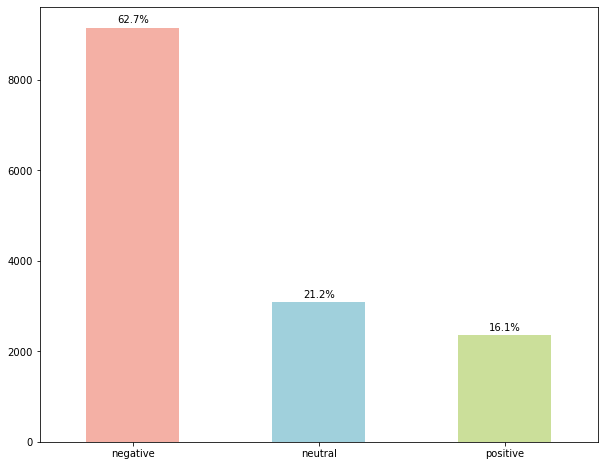

In [37]:
fig = plt.figure(figsize = (10,8))
data['airline_sentiment'].value_counts(dropna=False).plot(kind='bar', color = ['#f4b0a5','#a0d0dc','#cbdf9a'])
plt.xticks(rotation=0)
count = data['airline_sentiment'].value_counts(dropna= False)

for i in range(len(count)):
    percentage = '{:0.1f}%'.format(count[i]/data.shape[0] * 100)
    plt.text(i,count[i]+100,percentage,ha = 'center')

There are more negative sentiments than neutral and positive.

### Airline

Text(0.5, 1.0, 'Number of tweets for every Airline')

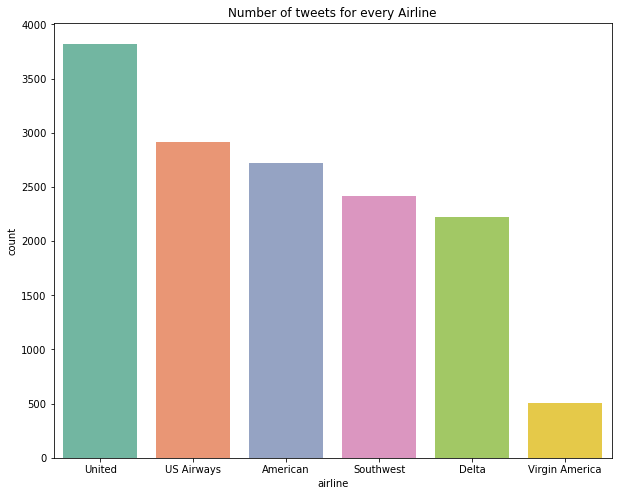

In [47]:
fig = plt.figure(figsize = (10,8))
sns.countplot(x = data['airline'], order = data['airline'].value_counts().index, palette='Set2').set_title('Number of tweets for every Airline')

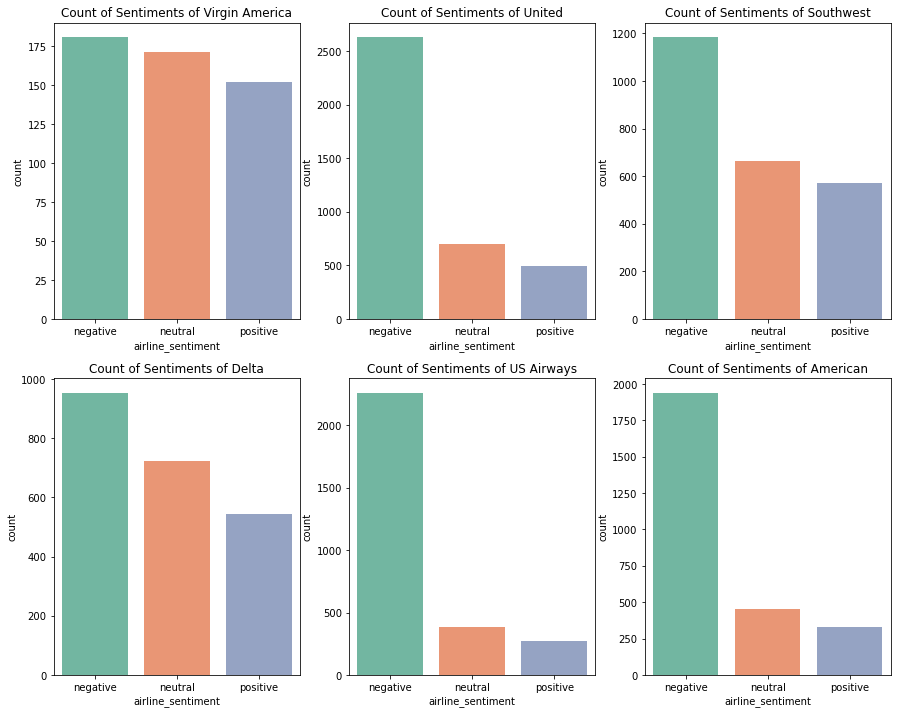

In [93]:
fig,ax = plt.subplots(nrows = 2, ncols = 3,figsize = (15,12))
airlines = list(data['airline'].unique())
for i in range(len(airlines)):
    air_data = data[data['airline'] == airlines[i]]
    sns.countplot(data = air_data, x = 'airline_sentiment', order = air_data['airline_sentiment'].value_counts().index, palette='Set2', ax = ax[i//3, i%3])
    ax[i//3, i%3].title.set_text('Count of Sentiments of ' + airlines[i])

            Percent Negative
American            0.712817
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


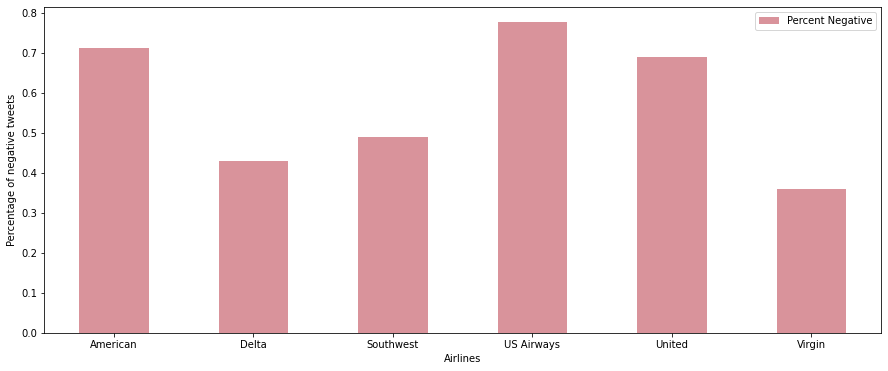

In [88]:
neg_tweets = data.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = data.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, color = '#d9939b', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

### Negative Reason

In [90]:
data['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

Text(0.5, 1.0, 'Number of tweets for every Negativereason')

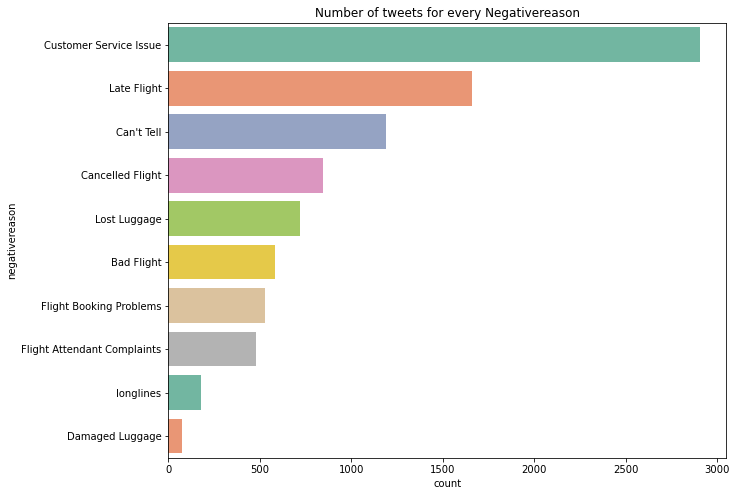

In [92]:
fig = plt.figure(figsize = (10,8))
sns.countplot(y = data['negativereason'], order = data['negativereason'].value_counts().index, palette='Set2').set_title('Number of tweets for every Negativereason')

Many negative tweets is due to customer service issue.

<AxesSubplot:xlabel='negativereason', ylabel='count'>

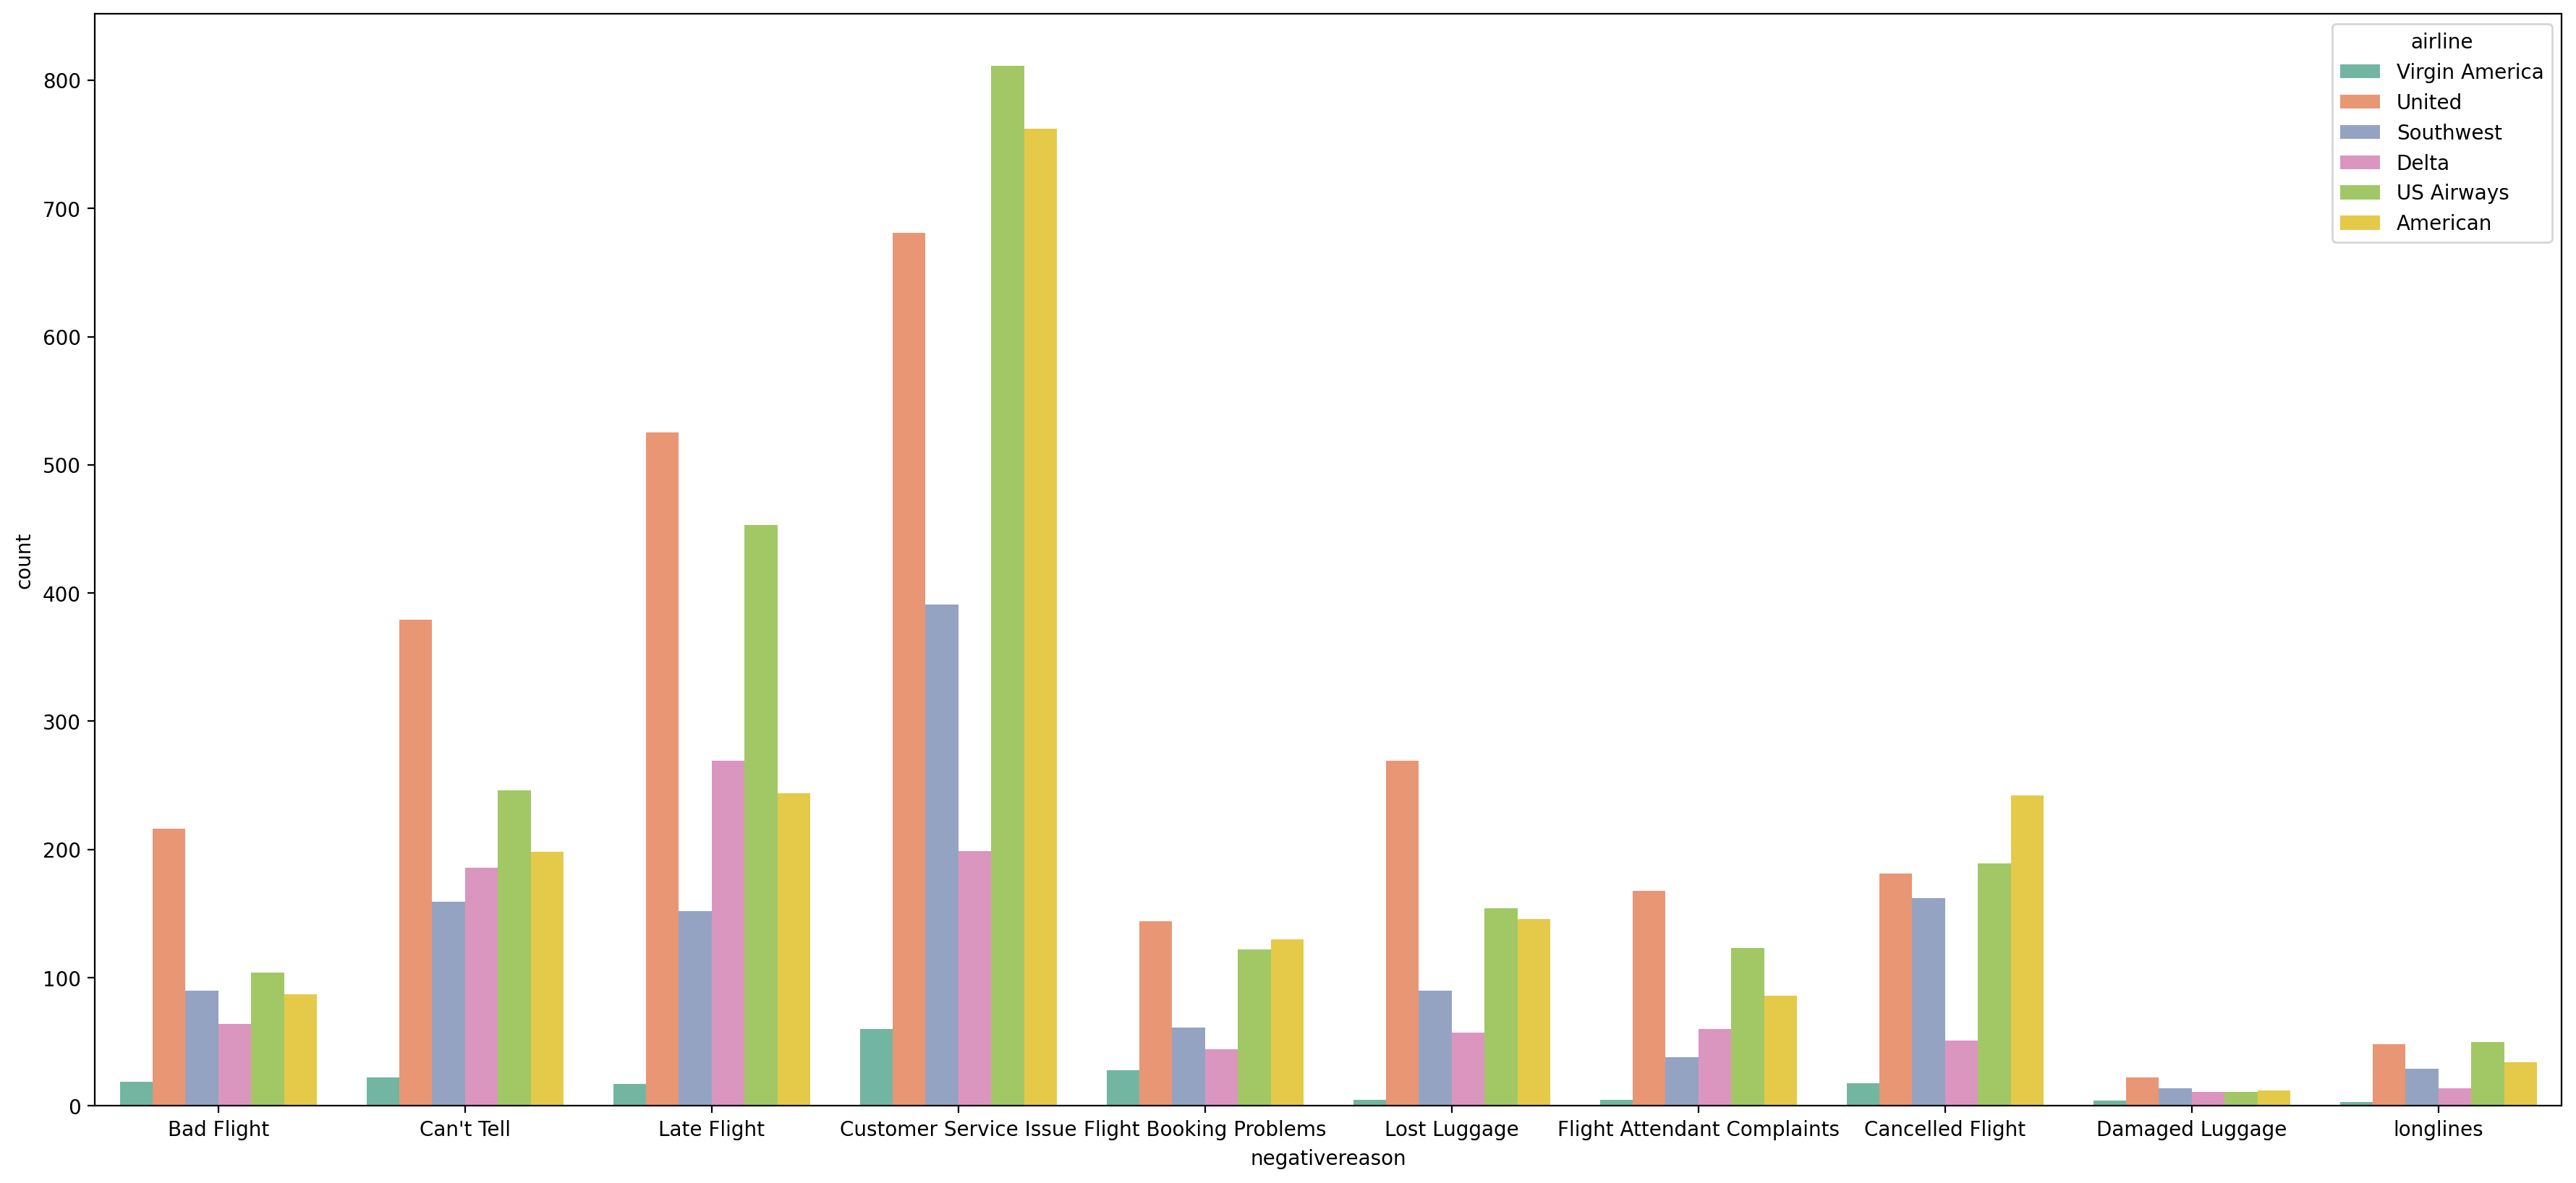

In [111]:
fig = plt.figure(figsize = (22,10),dpi = 200)
sns.countplot(data = data, x = 'negativereason', hue = 'airline', palette = 'Set2')

We can see Virgin America and Delta do better on customer service issue.

Customer service issue is the main negative reason for American, United, US Airways, Southwest and Virgin America.

Late Flight is the main negative reason for Delta.

### Date

In [113]:
date = data.reset_index()
date.tweet_created = pd.to_datetime(date.tweet_created)
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

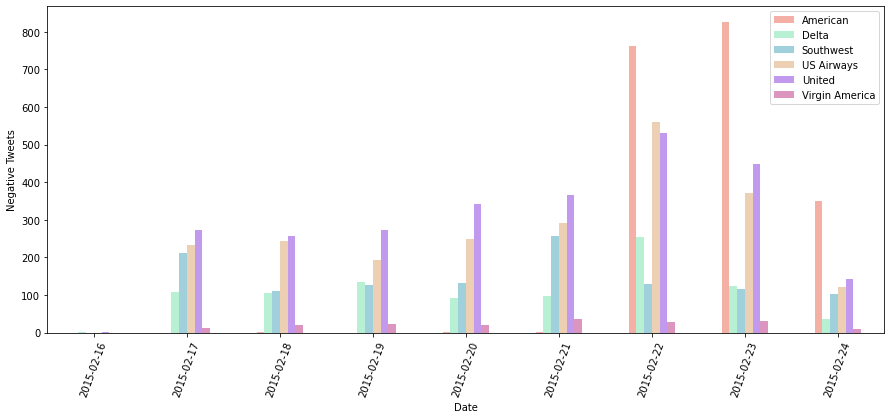

In [120]:
day_df = day_df.loc(axis=0)[:,:,'negative']

ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['#f4b0a5', '#b8f0d3', '#a0d0dc','#edcfb3','#c199ed','#dc95bf'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

American has a sudden increase in negative sentimental tweets on 2015-02-22 and 2015-02-23, which reduced to half the very next day 2015-02-24.

### Wordcloud for nagative and positive

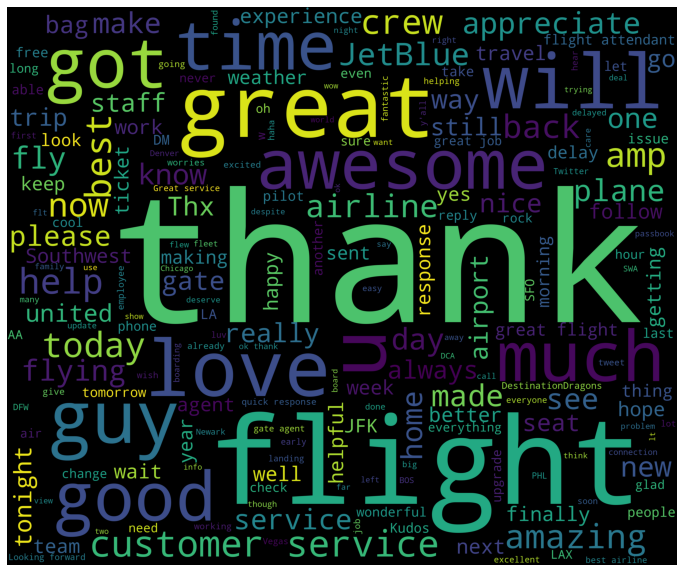

In [125]:
pos_data = data[data['airline_sentiment']=='positive']
words = ' '.join(pos_data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

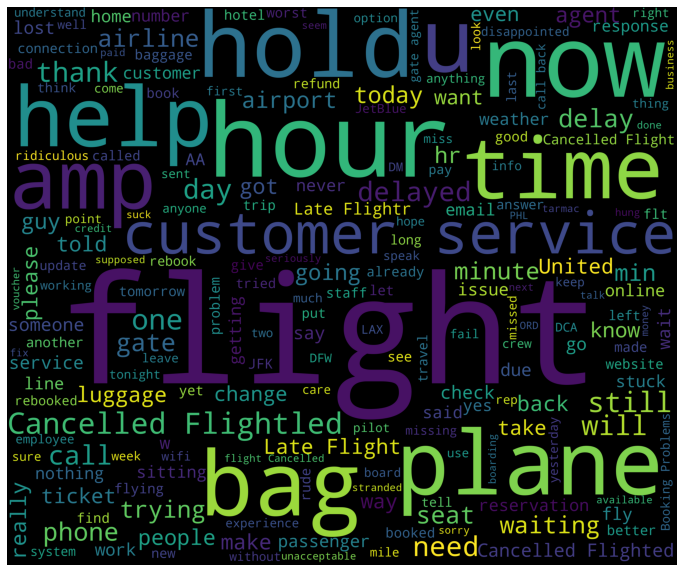

In [127]:
neg_data = data[data['airline_sentiment']=='negative']
words = ' '.join(neg_data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Feature Engineering

In [128]:
data.drop(data.loc[data['airline_sentiment']=='neutral'].index, inplace=True)

In [133]:
le = LabelEncoder()
le.fit(data['airline_sentiment'])

data['airline_sentiment_encoded'] = le.transform(data['airline_sentiment'])
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,airline_sentiment_encoded
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada),0
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24,NaN,Pacific Time (US & Canada),0
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24,San Francisco CA,Pacific Time (US & Canada),1


In [138]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

In [139]:
nltk.download('stopwords')
data['clean_tweet']=data['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangkeqing/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Vectorization

In [141]:
x = data.clean_tweet
y = data.airline_sentiment

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

8634 8634
2879 2879


In [146]:
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [147]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [148]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

## Modelling

In [150]:
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)

SVC(kernel='linear', random_state=10)

In [151]:
pred = model.predict(x_test_dtm)

In [152]:
accuracy_score(y_test,pred)

0.8996179228898923

In [156]:
cm = confusion_matrix(y_test, pred)
cm

array([[2169,  112],
       [ 177,  421]])

<AxesSubplot:>

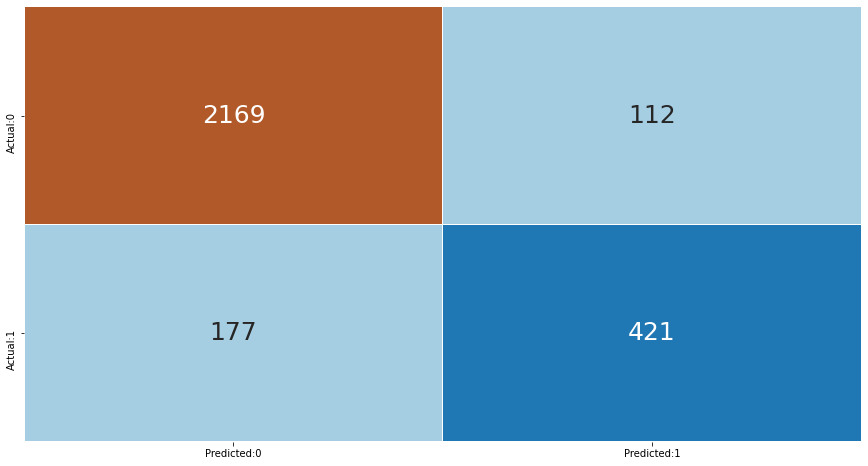

In [160]:
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})

In [161]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.92      0.95      0.94      2281
    positive       0.79      0.70      0.74       598

    accuracy                           0.90      2879
   macro avg       0.86      0.83      0.84      2879
weighted avg       0.90      0.90      0.90      2879

